In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from matplotlib.ticker import LinearLocator
from matplotlib import cm
import h5py
import argparse
from watpy.coredb.coredb import *
import os
import scipy.signal

In [ ]:
cdb = CoRe_db(r"C:\Users\aashr\Desktop\research\testing_grounds\CoRe_DB")
time_con_f = 4.975e-6

In [ ]:
gwf = cdb.sim["THC:0087"].run["R01"].data.read("rh_22")

In [ ]:
strain = gwf[:,1]
env = gwf[:,6]     
time = gwf[:,8]*time_con_f                         #converting to milliseconds

In [ ]:
def cut_at_lowest_envelope(hplus,env,time = None):
    #Cutting inspiral off
    cut_point = np.argmax(hplus)
    n = len(hplus)
    env_max = np.argmax(env)

    for l in range(env_max, n):
            if env[l] < env[l+1]:
                cut_point = l
                break
    if time is not None:
        return hplus[cut_point:], time[cut_point:]            
    return hplus[cut_point:]

In [ ]:
gs, gt = cut_at_lowest_envelope(strain,env,time = time)
plt.plot(time,strain)
plt.plot(gt,gs)

In [21]:
postmerger, pm_time = cut_at_lowest_envelope(strain,env,time = time)
name = "lol"
massA = 1
massB = 1
scale_min = 1
scale_max = 200
dscale = 0.01

sam_p = (pm_time[-1] - pm_time[0])/len(pm_time)
sam_f = 1/sam_p

83774.77240884448


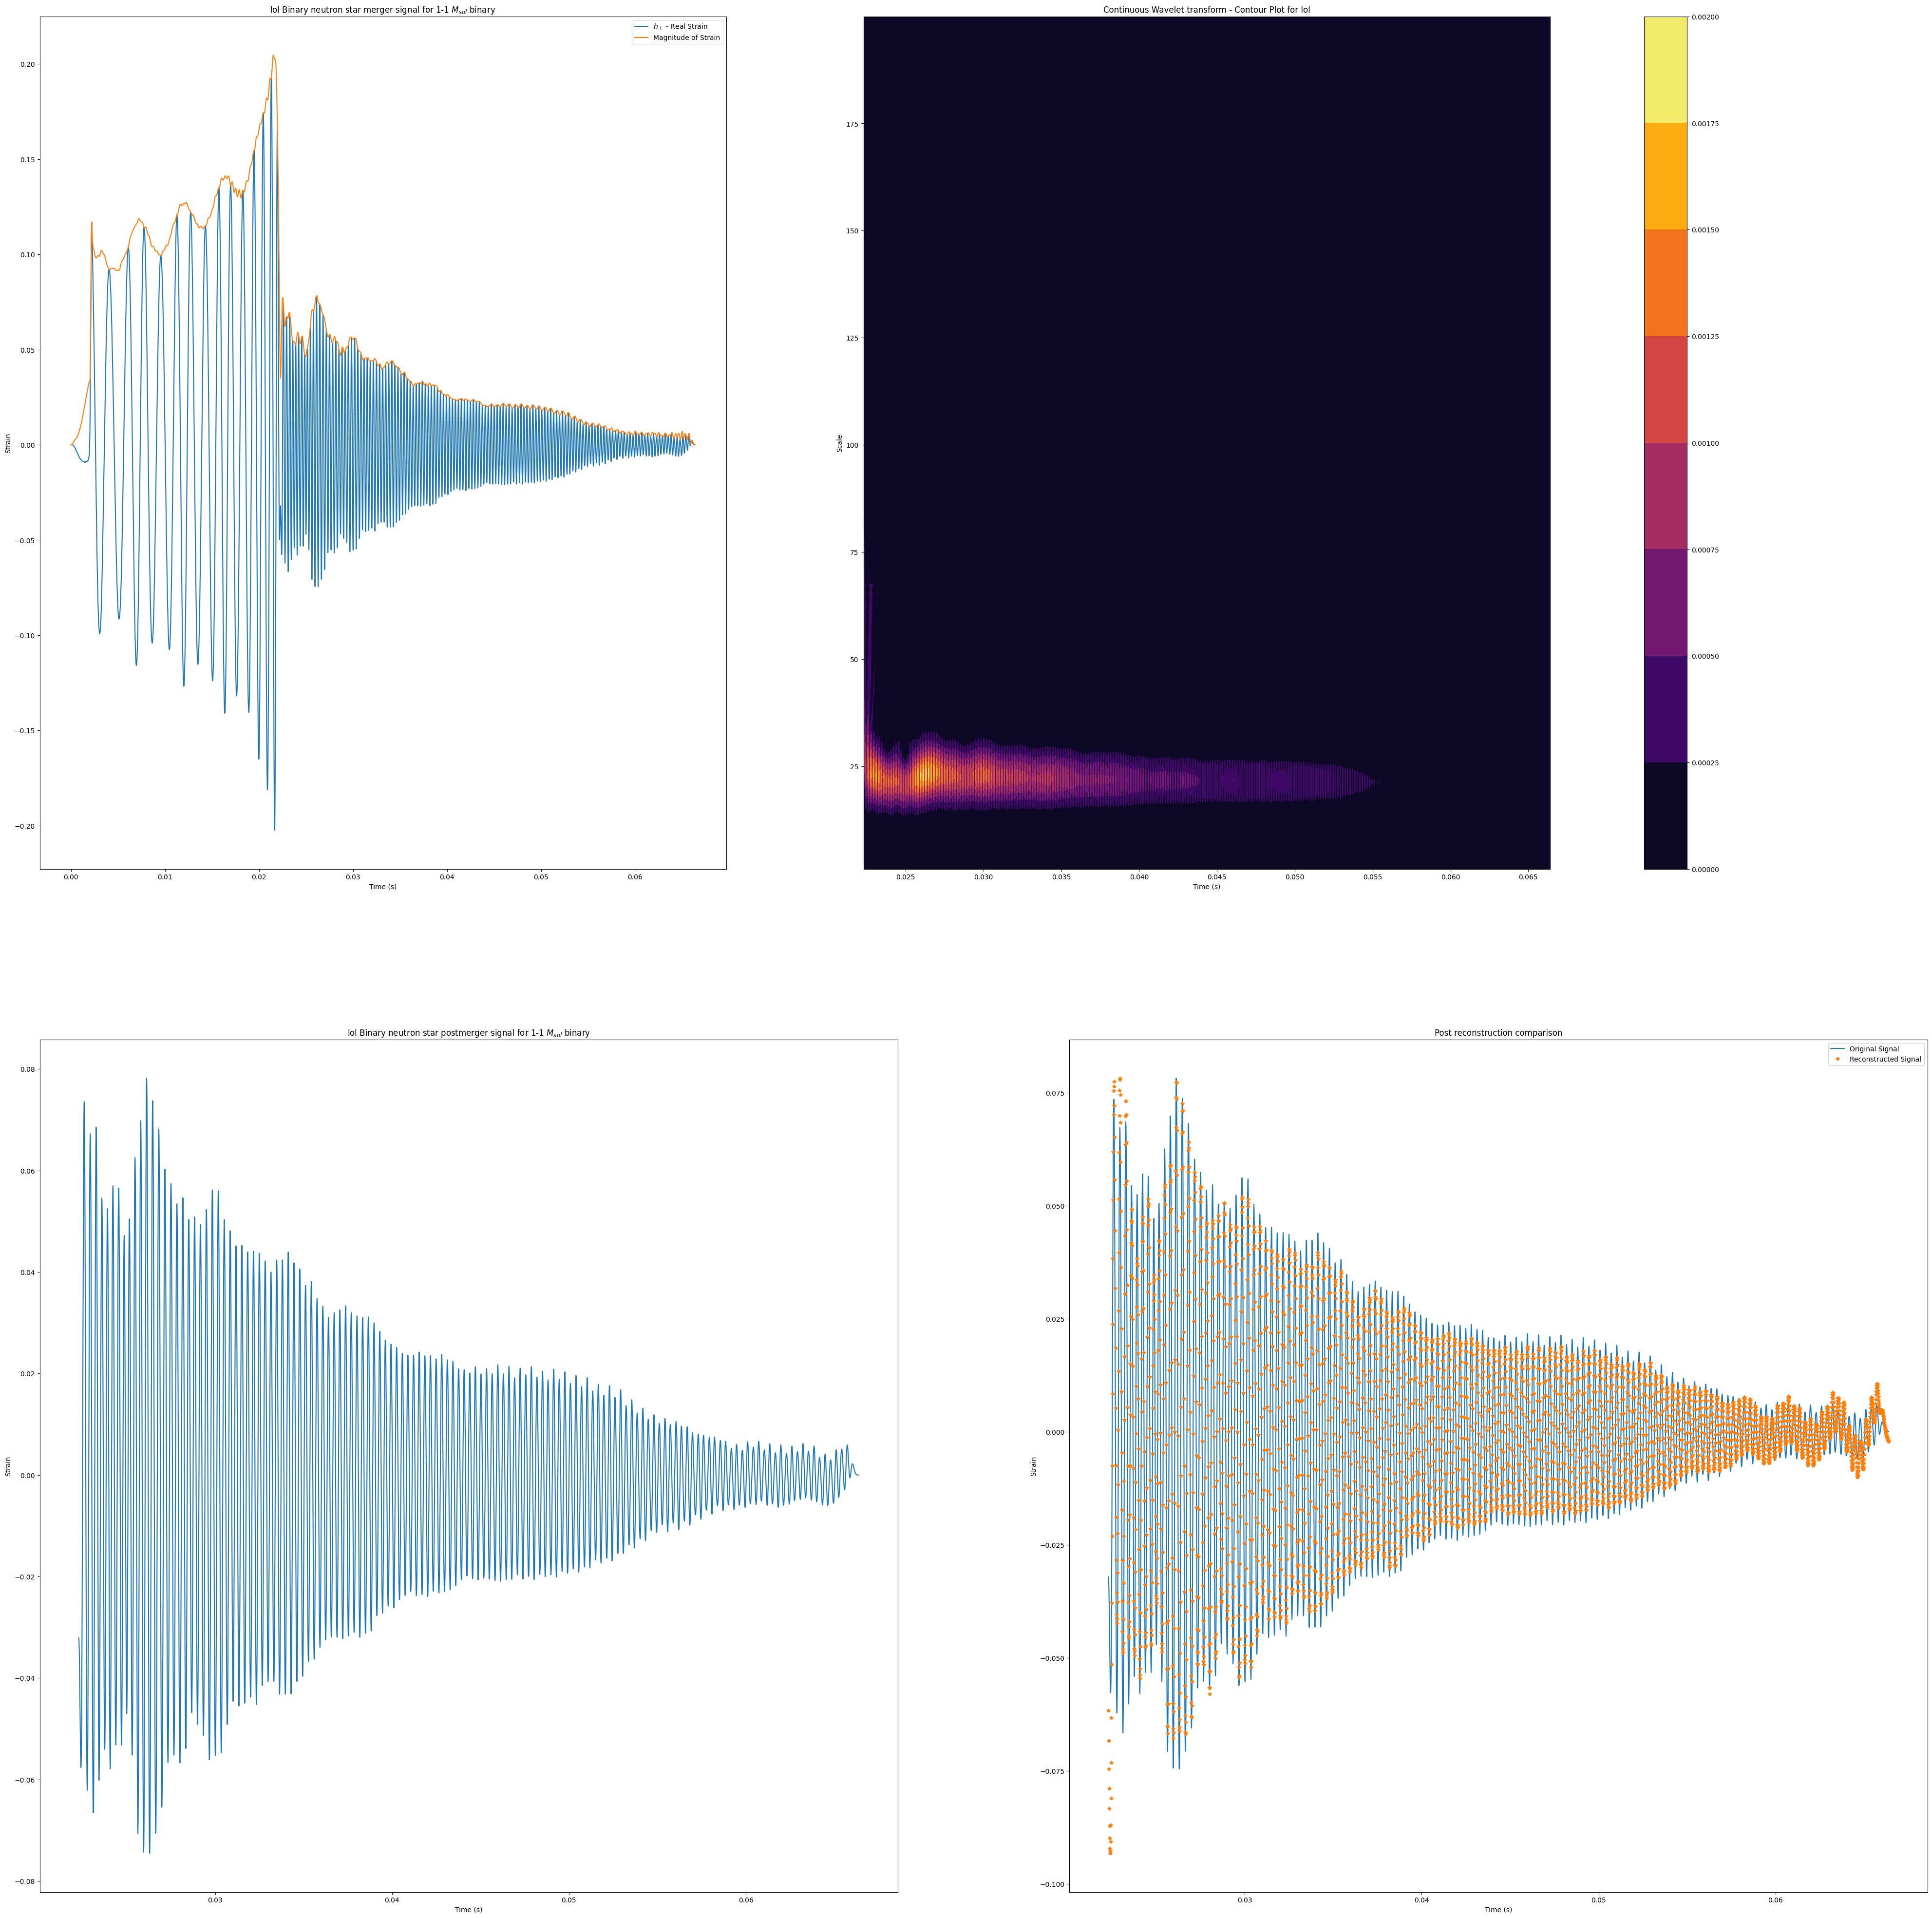

In [23]:
#Plotting the gwf
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(50,50))
ax[0][0].plot(time, strain, label = r'$h_+$ - Real Strain')
ax[0][0].plot(time, env, label = 'Magnitude of Strain')
#ax[0].plot(resamp_time, resampled, label = 'Resampled signal')
ax[0][0].legend()
ax[1][0].plot(pm_time, postmerger)
ax[0][0].set_xlabel('Time (s)')
ax[0][0].set_ylabel('Strain')
ax[0][0].set_title(name + ' Binary neutron star merger signal for ' + str(massA) + '-' + str(massB) + r' $M_{sol}$ binary')
ax[1][0].set_xlabel('Time (s)')
ax[1][0].set_ylabel('Strain')
ax[1][0].set_title(name + ' Binary neutron star postmerger signal for ' + str(massA) + '-' + str(massB) + r' $M_{sol}$ binary')
plt.savefig('./gwfplotfor'+ name +'.png')


#Defining sampling period and frequency
print(sam_f)

#Defining scale for the wavelet analysis
scales = np.arange(scale_min, scale_max, dscale)

#CWT on the gwf using the Morlet wavelet
coefs, freqs = pywt.cwt(postmerger, scales, 'morl', sampling_period = sam_p*4)

#Normalising the coefficient matrix using the Frobenius norm
norm_mat = (np.abs(coefs))/(np.linalg.norm(coefs))

#Reconstructing the signal
reconstructed = np.zeros_like(postmerger)
for n in range(len(pm_time)):
    reconstructed[n] = np.sum(coefs[:,n]/scales**0.5)
reconstructed = reconstructed/np.max(reconstructed)*np.max(postmerger)

X = pm_time
Y = scales
X, Y = np.meshgrid(X, Y)
Z = norm_mat
cp = ax[0][1].contourf(X, Y, Z, cmap = cm.inferno)
fig.colorbar(cp, ax=ax[0]) # Add a colorbar to a plot
ax[0][1].set_title('Continuous Wavelet transform - Contour Plot for '+ name)
ax[0][1].set_xlabel('Time (s)')
ax[0][1].set_ylabel('Scale')
ax[1][1].set_xlabel('Time (s)')
ax[1][1].set_ylabel('Strain')
ax[1][1].set_title('Post reconstruction comparison')
ax[1][1].plot(pm_time, postmerger, label='Original Signal')
ax[1][1].plot(pm_time, reconstructed,'*', label='Reconstructed Signal')
ax[1][1].legend()
plt.savefig('./gwave_trans_for' + name + '.png', bbox_inches="tight")
plt.show()

3694 51


Text(0.5, 0.98, 'lol BNSPM signal 1-1 $M_{sol}$ binary  at 83774.77240884448Hz')

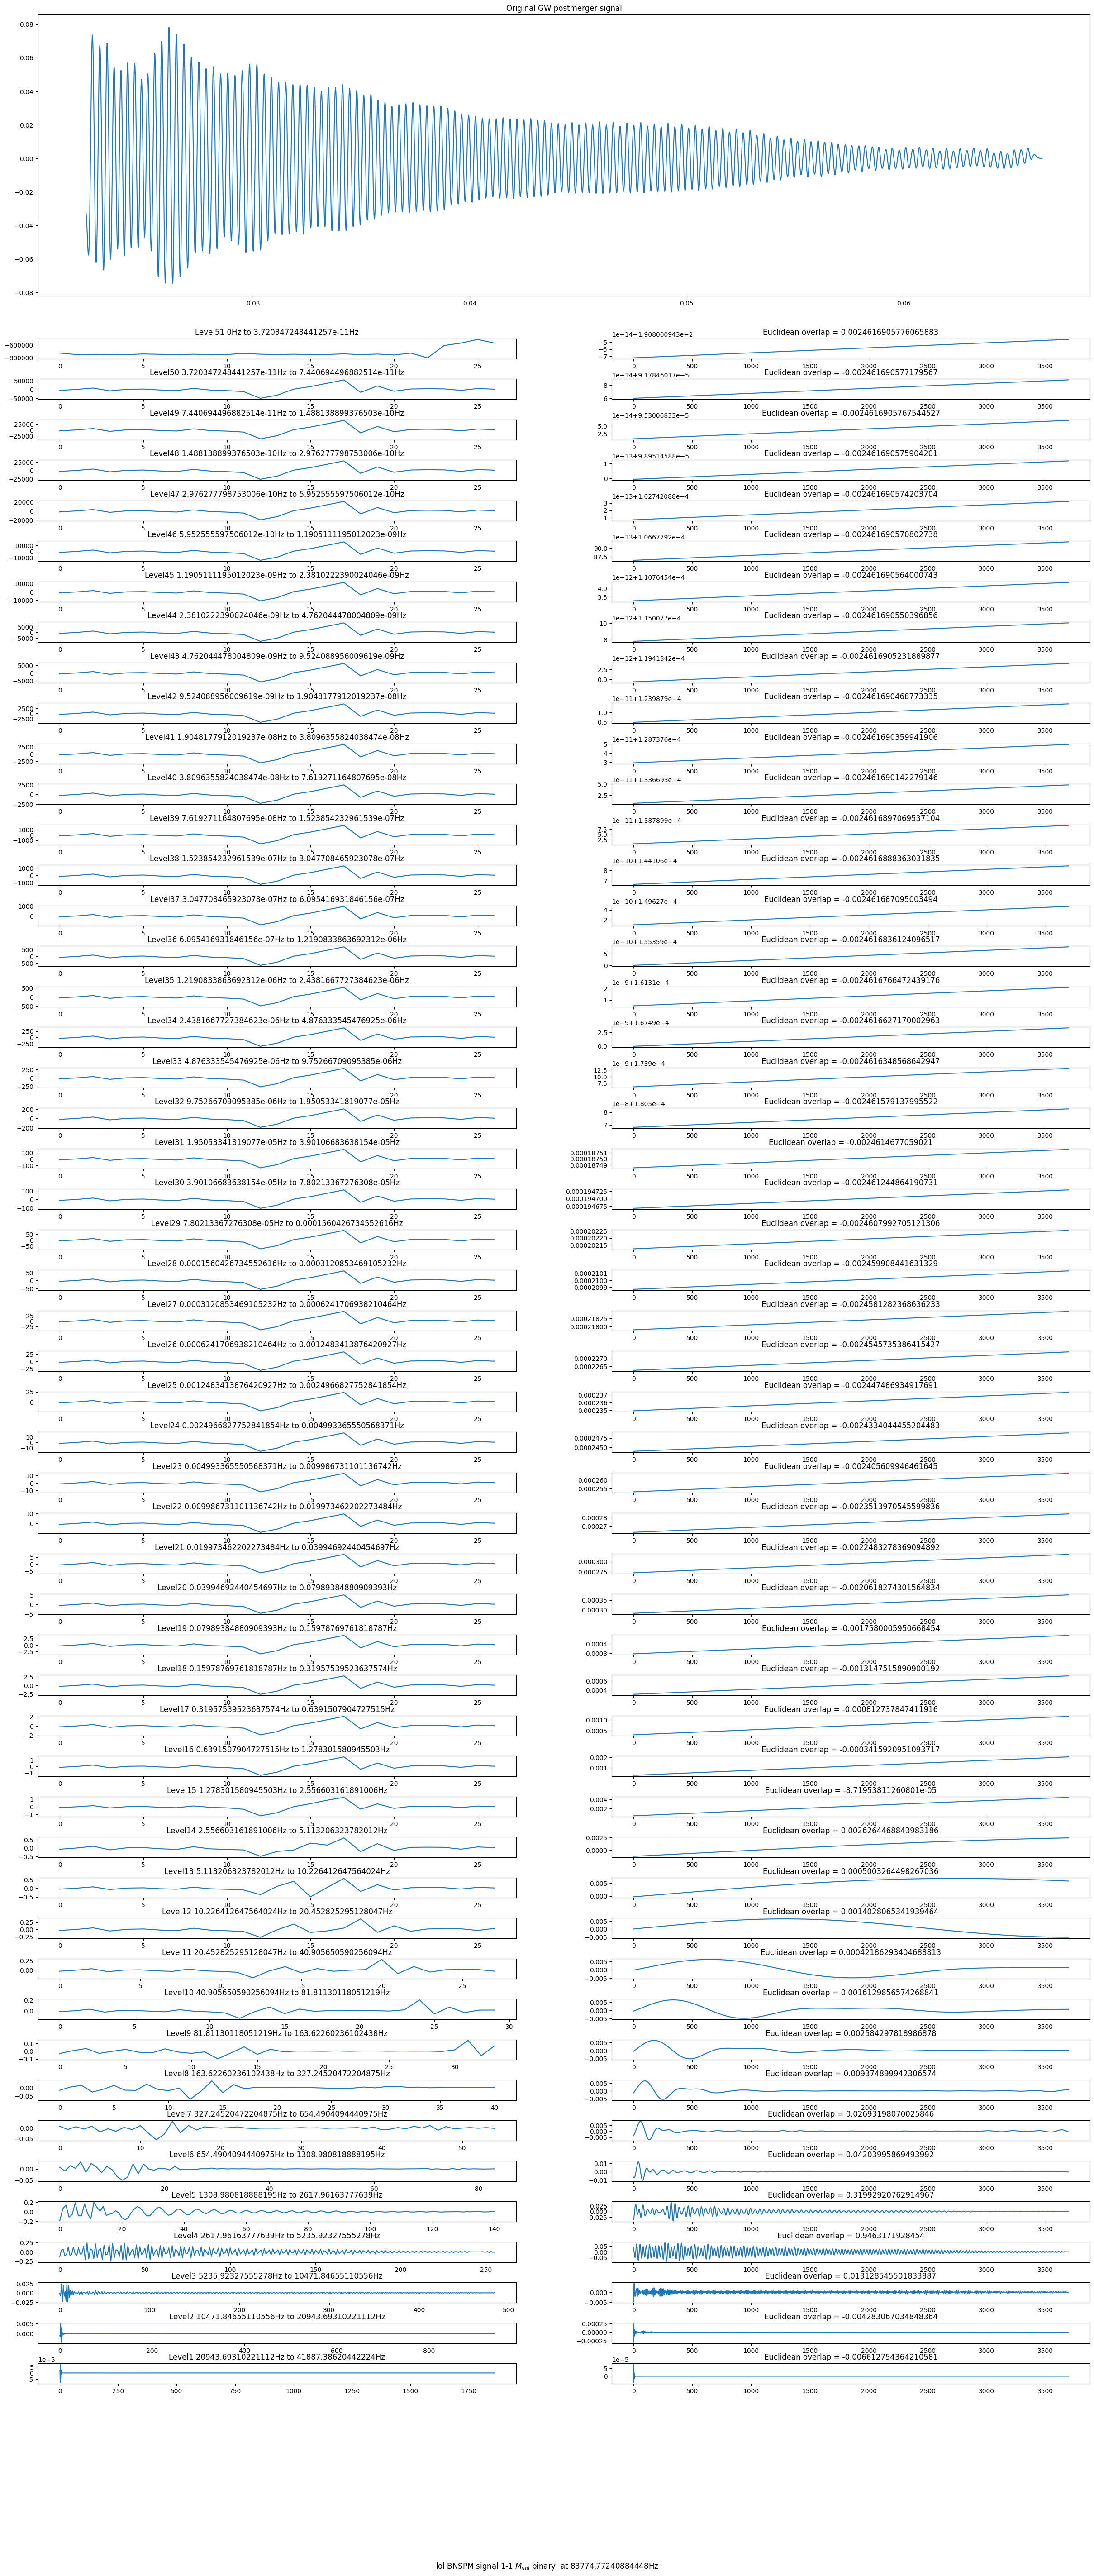

In [28]:
#Creating a wavelet object
waveletobj = pywt.Wavelet('db14')

levels = 50

#DWT on the gwf using the Morlet wavelet
coefs = pywt.wavedec(postmerger, waveletobj, level=levels)
print(len(postmerger), len(coefs))

fig = plt.figure(figsize=[15*2,7*2])

plt.subplots_adjust(hspace=1,top=5)

sub3 = fig.add_subplot(6,2,(1,2))
sub3.plot(pm_time, postmerger)
sub3.set_title('Original GW postmerger signal')

int_pm_sig = np.trapz(postmerger**2)

for itr in range(len(coefs)):
    ctr = (1/sam_p)/2
    sub1 = fig.add_subplot(int(levels*(3/2)+2),2,int(levels/3)+1+2*itr)
    sub1.plot(coefs[itr])
    if itr==0:
        sub1.set_title('Level' + str(len(coefs)-itr) + ' ' + '0Hz to ' + str(ctr/2**(len(coefs)-itr-1)) + 'Hz')
    else:
        sub1.set_title('Level' + str(len(coefs)-itr) + ' ' + str(ctr/2**(len(coefs)-itr)) + 'Hz to ' + str(ctr/2**(len(coefs)- itr-1)) + 'Hz')
    coefcp = [np.zeros_like(x) for x in coefs]
    coefcp[itr] = coefs[itr].copy()
    sig = pywt.waverec(coefcp, waveletobj)
    sigcp = sig.copy()
    sigcp = scipy.signal.resample(sigcp, len(postmerger))
    int_rec_sig = np.trapz(sigcp**2)
    int_both = np.trapz(postmerger*sigcp)
    euc_ov = int_both/(np.sqrt(int_pm_sig*int_rec_sig))
    sub2 = fig.add_subplot(int(levels*(3/2)+2),2,int(levels/3)+2+2*itr)
    sub2.plot(sig)
    sub2.set_title('Euclidean overlap = ' + str(euc_ov))



#ax[0,1].set_title('Level wise reconstruction')
fig.suptitle(name + ' BNSPM signal ' + str(massA) + '-' + str(massB) + r' $M_{sol}$ binary  at ' + str(1/sam_p) + 'Hz')


# plt.savefig('./' + name + '_levelwise.png')

# #Reconstructing the signal using complete information
# sig1 = pywt.waverec(coefs, waveletobj)
# rec =  coefs

# #Robi Polikar figure 4.2


# n = 0
# netl = 0
# for arr in coefs :
#     netl = netl + len(arr)

# flat_coef = np.zeros([netl])

# for arr in coefs:
#     flat_coef[n:n+len(arr)] = arr
#     n += len(arr)

#     if True:
#         x = np.arange(1,netl+1,1)
#         fig, ax = plt.subplots(2,1,figsize=[15,7])
#         ax[0].plot(pm_time, postmerger)
#         ax[0].set_title('GW signal being used')
#         ax[0].set_xlabel('Time')
#         ax[0].set_ylabel('Strain magnitude')

#         ax[1].plot(x, flat_coef)
#         ax[1].set_title('Coefficient amplitude vs DWT samples (mode-smooth padding)')
#         ax[1].set_xlabel('DWT coefficients')
#         ax[1].set_ylabel('Coefficient Amplitude')

        

#         plt.savefig('./coefamps'+ name +'.png')
#         plt.show()
#         plt.close()